## Imports

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import yfinance
import cpi
import scipy.stats as stats
import statsmodels.formula.api as smf
import scipy.stats as st
import networkx as nx
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Update CPI data to remove StaleDataWarning
# cpi.update()

## Data Preparation Parameters

In [86]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie Data Processing Functions

In [87]:
def movie_data_processing():
    """
    This function loads the data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    movies: pandas dataframe
        A dataframe containing the processed data
    """
    # Loading data from MovieSummaries dataset
    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
    
    # Renaming columns for clarity
    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    
    # Dropping unnecessary columns
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    
    # Processing columns with dictionaries
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))
    
    # Dropping duplicate entries based on Wikipedia movie ID
    movies.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)
    
    return movies
movies = movie_data_processing()

In [88]:
def process_dict_columns(movies):
    """
    This function processes the columns containing dictionaries in the movies dataframe
    It deletes some categories with less than Min_..._count movies and deletes movies with no categories left
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    movies: pandas dataframe
        The dataframe containing the processed data
    """
    
    # Extracting unique elements from columns with dictionaries
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])
    
    # Printing the number of unique elements for each category
    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))

    # Counting occurrences of each language, genre, and country
    # Creating dataframes for counts and filtering based on minimum count threshold
    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)
    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))

    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)
    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)
    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))
    
    # Filtering movies based on the remaining categories
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))
    
    # Removing movies with no categories left
    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [89]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    """
    This function processes the movie release date column.
    
    It deletes movies with no release date and modifies the format of the date.
    For the movies with no precise release date, it sets the release date to the 1st of January of the year of the movie
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    movies: pandas dataframe
        The dataframe containing the processed data
    """
    
    # Drop movies with non-string release dates
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    # Fixing a date error for a specific movie
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    # Modify release dates to have a uniform format
    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    # Extracting the release year and adding it as a separate column
    movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))
    
    return movies

movies = modify_movie_release_date(movies)

### Mergin revenue column with TMDB and adding budget

In [90]:
def modif_name(x):
    """
    Helper function to merge the movies dataframes on name and release year.
    
    Parameters
    ----------
    x: tuple
        A tuple containing two movie names.

    Returns
    -------
    str or bool:
        Returns the modified name if found in the 'movies' dataframe; otherwise, returns False.
    """
    if x.iloc[0].lower() in movies['modified name'].values:
        return x.iloc[0].lower()
    elif x.iloc[1].lower() in movies['modified name'].values:
        return x.iloc[1].lower()
    else:
        return False

def merge_revenue(x):
    """
    Helper function to merge the revenues from all the dataframes joined.
    
    Parameters
    ----------
    x: pandas Series
        A row from the joined dataframes.

    Returns
    -------
    float or np.nan:
        Returns the movie box office revenue if available; otherwise, returns NaN.
    """
    if x['Movie box office revenue']>0:
        return x['Movie box office revenue']
    elif x['revenue_left']>0:
        return x['revenue_left']
    elif x['revenue_right']>0:
        return x['revenue_right']
    else:
        return np.nan

def merge_budget(x):
    """
    Helper function to merge the budgets from all the dataframes joined.
    
    Parameters
    ----------
    x: pandas Series
        A row from the joined dataframes.

    Returns
    -------
    int or np.nan:
        Returns the movie budget if available; otherwise, returns NaN.
    """
    if type(x['budget_left'])==str and int(x['budget_left'])>0:
        return int(x['budget_left'])
    elif type(x['budget_right'])==str and int(x['budget_right'])>0:
        return int(x['budget_right'])
    else:
        return np.nan

def merging_revenu_budget(movies):

    """
    This function merges the movies dataframe with the data from the other datasets.
    It merges on the name and the release year.
    It also merges the revenue and the budget.
    
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    full_joined: pandas dataframe
        The dataframe containing the processed data
    """
    
    # Load additional datasets
    tmdb_scrapped = pd.read_csv('data/tmdb_scrapped_full.csv')
    tmdb_scrapped['release_year']=tmdb_scrapped['release_date'].map(lambda x: int(x.split('-')[0]))
    the_movies = pd.read_csv("data/the-movies-dataset/movies_metadata.csv")
    the_movies.dropna(subset=['title','original_title','release_date'],inplace=True)
    the_movies['release_year']=the_movies['release_date'].map(lambda x: int(x.split('-')[0]))
    
    # Modify the 'movies' dataframe
    movies['modified name']=movies['Movie name'].map(lambda x: x.lower())
    
    # Create modified names for 'the_movies' and 'tmdb_scrapped'
    names = []
    for i in the_movies.index:
        names.append(modif_name(the_movies.loc[i,['title','original_title']]))
    the_movies['modified name']=names

    names = []
    for i in tmdb_scrapped.index:
        names.append(modif_name(tmdb_scrapped.loc[i,['title','original_title']]))
    tmdb_scrapped['modified name']=names
    
    # Join the dataframes
    temporary_joined = movies.join(the_movies.set_index(['modified name',"release_year"]), on=['modified name','Movie Year Release'], how='left', lsuffix='_left', rsuffix='_right')
    full_joined = temporary_joined.join(tmdb_scrapped.set_index(['modified name',"release_year"]), on=['modified name','Movie Year Release'], how='left', lsuffix='_left', rsuffix='_right')
    full_joined.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)

    # Calculate full revenue and full budget
    L= []
    for i in full_joined.index:
        L.append(merge_revenue(full_joined.loc[i]))
    full_joined['full revenue']=L

    L1= []
    for i in full_joined.index:
        L1.append(merge_budget(full_joined.loc[i]))
    full_joined['full budget']=L1

    # Drop unnecessary columns
    full_joined.drop(['modified name',"adult_left","belongs_to_collection_left",'budget_left', 'genres_left', 'homepage_left', 'id_left','imdb_id_left', 'original_language_left', 'original_title_left',
       'overview_left', 'popularity_left', 'poster_path_left','production_companies_left', 'production_countries_left','release_date_left', 'revenue_left', 'runtime_left',
       'spoken_languages_left', 'status_left', 'tagline_left', 'title_left','video_left', 'vote_average_left', 'vote_count_left', 'Unnamed: 0.1','Unnamed: 0', 'adult_right', 'backdrop_path',
       'belongs_to_collection_right', 'budget_right', 'genres_right','homepage_right', 'id_right','original_language_right', 'original_title_right', 'overview_right',
       'popularity_right', 'poster_path_right', 'production_companies_right','production_countries_right', 'release_date_right', 'revenue_right','runtime_right', 'spoken_languages_right', 'status_right','tagline_right', 'title_right', 'video_right', 'vote_average_right',
       'vote_count_right'],axis=1,inplace=True)
    
    # Drop the original movie box office revenue column
    full_joined.drop(['Movie box office revenue'],axis=1,inplace=True)
    
    # Rename columns
    full_joined.rename(columns={'imdb_id_right':'IMDB id','full revenue':'Movie box office revenue','full budget':'Movie budget'},inplace=True)
    return full_joined

full_joined = merging_revenu_budget(movies)

#or this if you want to gain time:
# full_joined = pd.read_csv('data/movie_with_merged_revenue.csv')
movies=full_joined.copy()

/tmp/ipykernel_372215/1671624593.py:86: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  the_movies = pd.read_csv("data/the-movies-dataset/movies_metadata.csv")


### Characters

In [91]:
def characters_data_process():
    """
    This function loads the characters data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    characters: pandas dataframe
        A dataframe containing the processed data
    """
    
    # Load characters data
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    
    # Rename columns for better readability
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    
    # Drop unnecessary columns
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    # Drop 'Actor ethnicity (Freebase ID)' as it might not be useful
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)
    
    # Process 'Movie release date'
    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    # Correct a date error
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    
    # Drop rows with missing values in 'Character name' or 'Actor name'
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)
    
    # Filter characters data to include only those in the 'movies' dataframe
    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    
    return characters
characters = characters_data_process()

### Plot Summaries

In [92]:
def plot_summaries_data_process():
    """
    This function loads the plot summary data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    plot_summaries: pandas dataframe
        A dataframe containing the processed data
    """
    
    # Load plot summaries data
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    
    # Rename columns for better readability
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    
    # Drop rows with missing values in 'Plot summary'
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    
    # Filter plot summaries data to include only those in the 'movies' dataframe
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### Add rotten tomatoes critic score

In [93]:
def processing_rotten_tomatoes_score():
    """
    This function loads the data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    movies: pandas dataframe
        A dataframe containing the processed data
    """
    # Load data from 'rotten_tomatoes_movies.csv'
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)
    
    # Drop unnecessary columns
    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    # Drop rows with missing values in specified columns
    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating','original_release_date'], inplace=True)
    
    # Extract the release year from 'original_release_date' and create a new column 'Movie Year Release'
    rotten_movies['Movie Year Release'] = rotten_movies['original_release_date'].map(lambda x: int(x.split('-')[0]))
    
    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()

# Join on movie name and release year
joined_2_movies = movies.join(rotten_movies.set_index(['movie_title', 'Movie Year Release']), on=['Movie name', 'Movie Year Release'], how='left')
joined_2_movies.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)
# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

#OK but still some film have different release data on the two dataset=> Wilde 
# Assign the merged dataframe back to 'movies'
movies = joined_2_movies

# Correlations between ratings and box office revenue
The Pearson correlation $r$ can be given by the coefficient of the ols applied on standardized data. To do so, one needs to use the following transformation:
$ z = \frac{x-\mu}{\sigma}$
where $x$ is the original value, $z$ is the standardized value, $\mu$ the mean of the data and $\sigma$ its standard deviation. 

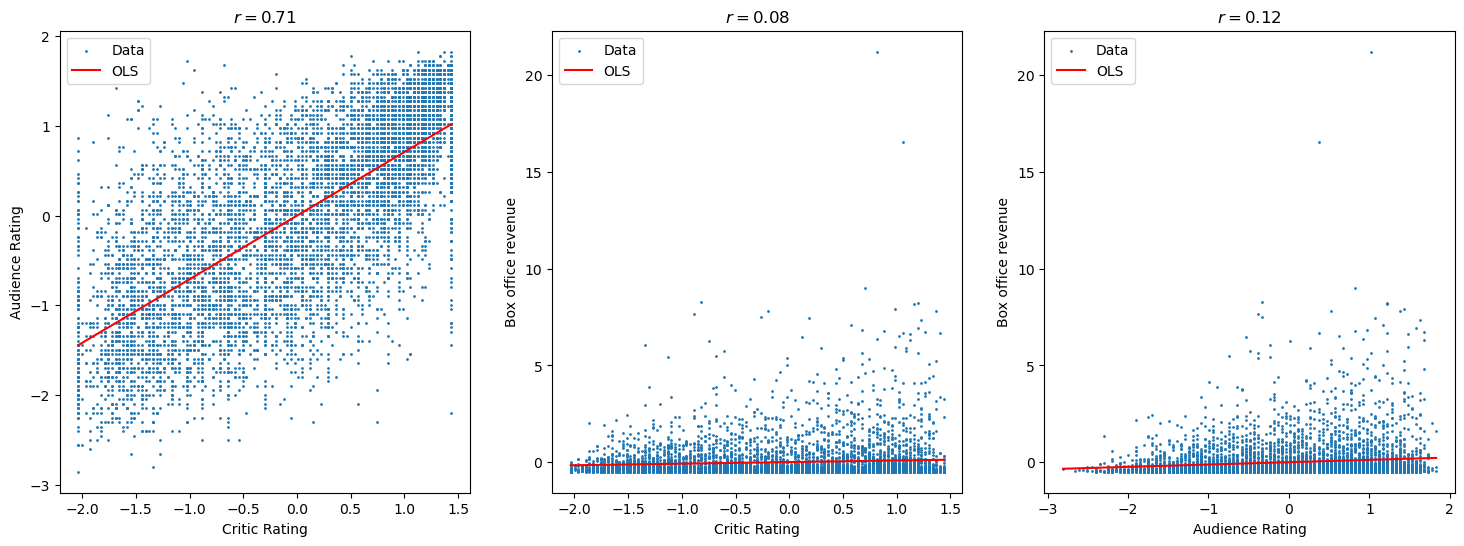

In [94]:
def compute_plot_correlations(df):
    """
    Compute and vizualize correlations using z score and ols. Correlations computed are between 'audience_rating', 'tomatometer_rating' and 'Movie box office revenue'.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the 'audience_rating', 'tomatometer_rating' and 'Movie_box_office_revenue'.

    Returns:
    np.Array: correlations in the following order 0. 'audience_rating' - 'tomatometer_rating'
                                                  1. 'audience_rating' - 'Movie box office revenue'
                                                  2. 'tomatometer_rating' - 'Movie box office revenue'
    """
    # Remove the movie with NaN values for audience_rating (which are the same movies for tomatometer_rating)
    rating = df[df.audience_rating.notnull()].copy()
    
    # Changing the name of the 'Movie box office revenue" column to make it easier when using the ols function from the smf library
    rating = rating.rename(columns={'Movie box office revenue':'Movie_box_office_revenue'})
    
    # Applying a standardization to make the correlation appear from the coefficient given by the ols
    rating['tomatometer_rating_norm'] = stats.zscore(rating['tomatometer_rating'])
    rating['audience_rating_norm'] = stats.zscore(rating['audience_rating'])
    
    # Plotting the results
    plt.figure(figsize=(18, 6))
    # For 'audience_rating' - 'tomatometer_rating'
    plt.subplot(1, 3, 1)
    mod = smf.ols(formula='audience_rating_norm ~ tomatometer_rating_norm', data=rating)
    reg = mod.fit()
    plt.scatter(rating.tomatometer_rating_norm, rating.audience_rating_norm,s=1)
    min_critic = min(rating['tomatometer_rating_norm'])
    max_critic = max(rating['tomatometer_rating_norm'])
    x_reg = np.linspace(min_critic,max_critic,100)
    y_reg =reg.params.iloc[0] +reg.params.iloc[1]*x_reg
    plt.plot(x_reg, y_reg, '-r')
    plt.xlabel('Critic Rating')
    plt.ylabel('Audience Rating')
    plt.legend(['Data', 'OLS'])
    plt.title('$r = %1.2f $' % reg.params.iloc[1])
    # For 'tomatometer' - 'Movie box office revenue'
    plt.subplot(1, 3, 2)
    # Consider only the movie without NaN in the "Movie_box_office_revenue' column
    rating_box_office = rating[rating['Movie_box_office_revenue'].notnull()].copy()
    rating_box_office['Movie_box_office_revenue_norm'] = stats.zscore(rating_box_office['Movie_box_office_revenue'])
    mod = smf.ols(formula='Movie_box_office_revenue_norm ~ tomatometer_rating_norm', data=rating_box_office)
    reg = mod.fit()
    plt.scatter(rating_box_office.tomatometer_rating_norm, rating_box_office.Movie_box_office_revenue_norm,s=1, marker='o')
    y_reg =reg.params.iloc[0] +reg.params.iloc[1]*x_reg
    plt.plot(x_reg,y_reg, '-r')
    plt.xlabel('Critic Rating')
    plt.ylabel('Box office revenue')
    plt.legend(['Data', 'OLS'])
    plt.title('$r = %1.2f $' % reg.params.iloc[1])
    # For 'audience_rating' - 'Movie box office revenue'
    plt.subplot(1, 3, 3)
    mod = smf.ols(formula='Movie_box_office_revenue_norm ~ audience_rating_norm', data=rating_box_office)
    reg = mod.fit()
    plt.scatter(rating_box_office.audience_rating_norm, rating_box_office.Movie_box_office_revenue_norm,s=1, marker='o')
    min_audience = min(rating_box_office['audience_rating_norm'])
    max_audience = max(rating_box_office['audience_rating_norm'])
    x_reg = np.linspace(min_audience, max_audience, 100)
    y_reg = reg.params.iloc[0] +reg.params.iloc[1]*x_reg
    plt.plot(x_reg, y_reg, '-r')
    plt.xlabel('Audience Rating')
    plt.ylabel('Box office revenue')
    plt.legend(['Data', 'OLS'])
    plt.title('$r = %1.2f $' % reg.params.iloc[1])

compute_plot_correlations(movies)

The correlation between the audience and the critic is reasonable without being perfect. However, the correlation between the different ratings and the box office revenue are both very low exhibiting the weak link between the quality of the movie and this financial metric. Therefore, it will be interesting to keep track of ratings and box office revenue as two different success measures. This will allow movie producers to adapt their process in order meet to their desired type of success.

## Financial success

We load CPI data to compare the movie box office return through history. Furthermore, we load financial data to analyse if economics data are related with success for some period 


### First definition of success

In [ ]:
# Calculate the mean revenue for each release year
m = movies[movies["Movie Year Release"]<2020]
mean_revenue_year = m.groupby('Movie Year Release')['Movie box office revenue'].mean()

# Normalize revenue for each movie based on its release year's mean revenue
for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

# Categorize movies as financially successful if their normalized revenue exceeds a specified threshold
movies["Finantial Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold

# Set 'Financial Success' to NaN when 'Normalized revenue' is NaN (missing data)
movies.loc[movies["Movie box office revenue"].isna(), "Finantial Success"] = np.nan


C:\Users\maxen\AppData\Local\Temp\ipykernel_10368\76960079.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  movies.loc[movies["Movie box office revenue"].isna(), "Finantial Success"] = np.nan


### Analysis of inflation

PearsonRResult(statistic=0.904935756656554, pvalue=3.726882394272742e-35)


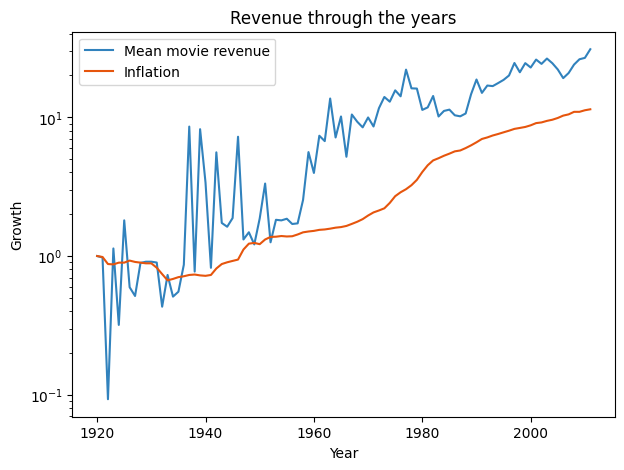

In [ ]:
# Importing Consumer Price Index (CPI) data using the cpi Python library

# Retrieve CPI series data and convert it to a DataFrame
cpi_df = cpi.series.get().to_dataframe()

# Filter the DataFrame to include only monthly period types
cpi_df = cpi_df[cpi_df['period_type']=='monthly']

# Convert the 'date' column to datetime format
cpi_df['date'] = pd.to_datetime(cpi_df['date'])

# Set the 'date' column as the index and sort the DataFrame by date
cpi_df = cpi_df.set_index('date').sort_values(by="date")
# Extract the year and month from the 'date' column
cpi_df['year'] = cpi_df.index.year
cpi_df['month'] = cpi_df.index.month

# Filter rows where the month is 1 (January)
january_dates = cpi_df[cpi_df['month'] == 1]
january_dates = january_dates[january_dates["year"]>=1920]
january_dates = january_dates[january_dates["year"]<=2011]


print(st.pearsonr(january_dates["value"]/(january_dates["value"].iloc[0]), mean_revenue_year.dropna().loc[1920:2011]/(mean_revenue_year.dropna().loc[1920]), alternative='two-sided', method=None))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.semilogy(mean_revenue_year.loc[1920:2011]/(mean_revenue_year.dropna().loc[1920]), label="Mean movie revenue", color=plt.cm.tab20c(0))
ax.semilogy(january_dates["year"], january_dates["value"]/(january_dates["value"].iloc[0]), label="Inflation", color=plt.cm.tab20c(1/5))
plt.xlabel("Year")
plt.ylabel("Growth")
ax.set_title("Revenue through the years")
ax.legend()

#### Adjust the effect of inflation on the movie revenue

In [ ]:
# we add an inflated revenue column, corresponding to the movie box office revenue increased to today's value according to inflation

movies["Inflated_revenue"]=movies.apply(lambda x: cpi.inflate(x["Movie box office revenue"], x["Movie Year Release"]) if (not(np.isnan(x["Movie box office revenue"])))else None, axis=1)

### Financial success

We now compare a financial indicator with the increase of movie revenue through history

In [ ]:
# importing S&P 500 data to compare with movie revenue
gspc = yfinance.download("^GSPC", start = pd.to_datetime(movies["Movie Year Release"].min(), format="%Y"), end=pd.to_datetime(movies["Movie Year Release"].max()+1, format="%Y"))
financial_index = (gspc["Close"].diff().shift(-1)/gspc["Close"]).shift(1)



[*********************100%%**********************]  1 of 1 completed


In [ ]:
# This cell turn our daily data into a single value for a defined number months
# The value is computed as the product of the single returns


initial_date = financial_index.index.min()+pd.DateOffset(months=1)-pd.DateOffset(days=financial_index.index.min().day-1)
final_date = pd.to_datetime(movies["Movie Year Release"].max()+1, format="%Y")
financial_indicator = pd.Series()
date_start = initial_date

# Hyperparameter number of months
number_of_months = 6

while(date_start<(final_date)):
    date_end = date_start+pd.DateOffset(months=number_of_months)
    financial_indicator[date_start] = np.prod(1+(financial_index.loc[date_start:date_end]).shift(-1))-1
    date_start = date_end

# you can also play with this in order to smooth the periods
#financial_indicator = financial_indicator.rolling(window=12).mean()

financial_indicator.head()

1928-01-01    0.077703
1928-07-01    0.282929
1929-01-01    0.119307
1929-07-01   -0.227584
1930-01-01   -0.044382
dtype: float64

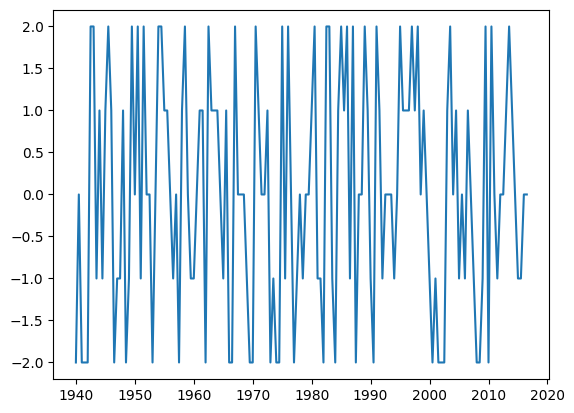

In [ ]:
# Define the quantile thresholds
quantiles = [financial_indicator.min()] + list(financial_indicator.quantile([0.2, 0.4, 0.6, 0.8])) + [financial_indicator.max()]

# Define the corresponding labels for the discrete Series
labels = [-2, -1, 0, 1, 2]

# Use pd.cut to discretize the Series based on the quantile thresholds and labels
discrete_financial = pd.cut(financial_indicator, bins=quantiles, labels=labels, include_lowest=True)


# PLot the result
plt.plot(discrete_financial.loc["1940-01-01":])


The previous figure represents the global state of the economy on the last 4 months, from -2 to +2, with higher value corresponding to a better state of the economy. We observe that our graphs is relatively noisy.

In [ ]:
# In this cell, we create a column corresponding to the state of the economy at the movie release date

financial_context = pd.merge_asof(pd.DataFrame(pd.to_datetime(movies["Movie release date"])).sort_values(by="Movie release date"), pd.DataFrame(discrete_financial.rename("Financial_context")), left_on="Movie release date",  right_index=True, direction='forward')#, suffixes=('_df', '_serie'))

movies_financial_context = pd.merge(movies, financial_context["Financial_context"], left_index=True, right_index=True)


c:\Users\maxen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

Text(0.5, 1.0, 'Revenue depending on economic context')

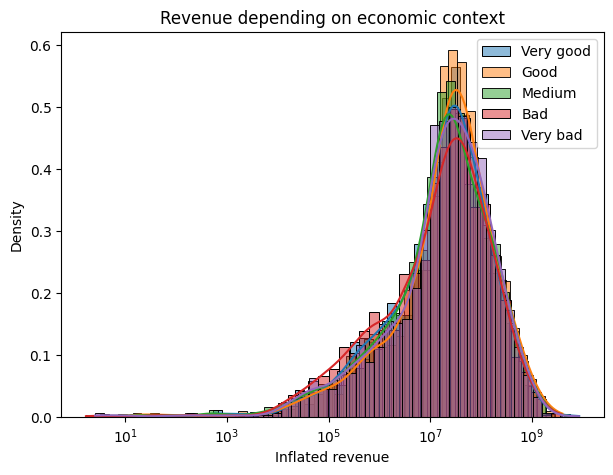

In [ ]:
# We plot the distribution of the movie revenue for each movie context

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.histplot(movies_financial_context[movies_financial_context['Financial_context'] == 2]['Inflated_revenue'], ax=ax, label='Very good',stat="density",kde=True, log_scale=True)
sns.histplot(movies_financial_context[movies_financial_context['Financial_context'] == 1]['Inflated_revenue'], ax=ax, label='Good',stat="density",kde=True, log_scale=True)
sns.histplot(movies_financial_context[movies_financial_context['Financial_context'] == 0]['Inflated_revenue'], ax=ax, label='Medium',stat="density",kde=True, log_scale=True)
sns.histplot(movies_financial_context[movies_financial_context['Financial_context'] == -1]['Inflated_revenue'], ax=ax, label='Bad',stat="density",kde=True, log_scale=True)
sns.histplot(movies_financial_context[movies_financial_context['Financial_context'] == -2]['Inflated_revenue'], ax=ax, label='Very bad',stat="density",kde=True, log_scale=True)
ax.legend()
ax.set_xlabel('Inflated revenue')
ax.set_title("Revenue depending on economic context")



In [ ]:
# We also do a linear regression of inflated revenue with financial context

st.linregress(movies_financial_context[["Inflated_revenue", "Financial_context"]].dropna())


LinregressResult(slope=3.5787068173283534e-11, intercept=-0.00876013380523797, rvalue=0.006363169784108407, pvalue=0.5108034052900933, stderr=5.4419956519083647e-11, intercept_stderr=0.014034643658629737)

We observe that all the cluster have similar density across the economic states. Therefore, economic context does not seem to affect the movie box office revenue.

## Movie Duration Graph Analysis & Comparison

An analysis of the performance of a film based on its duration and its release month


/home/joseph/docs/epfl/applied-data-analysis/project/ada-2023-project-madafaka1/helpers.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_movies.groupby('Length Bin').agg({


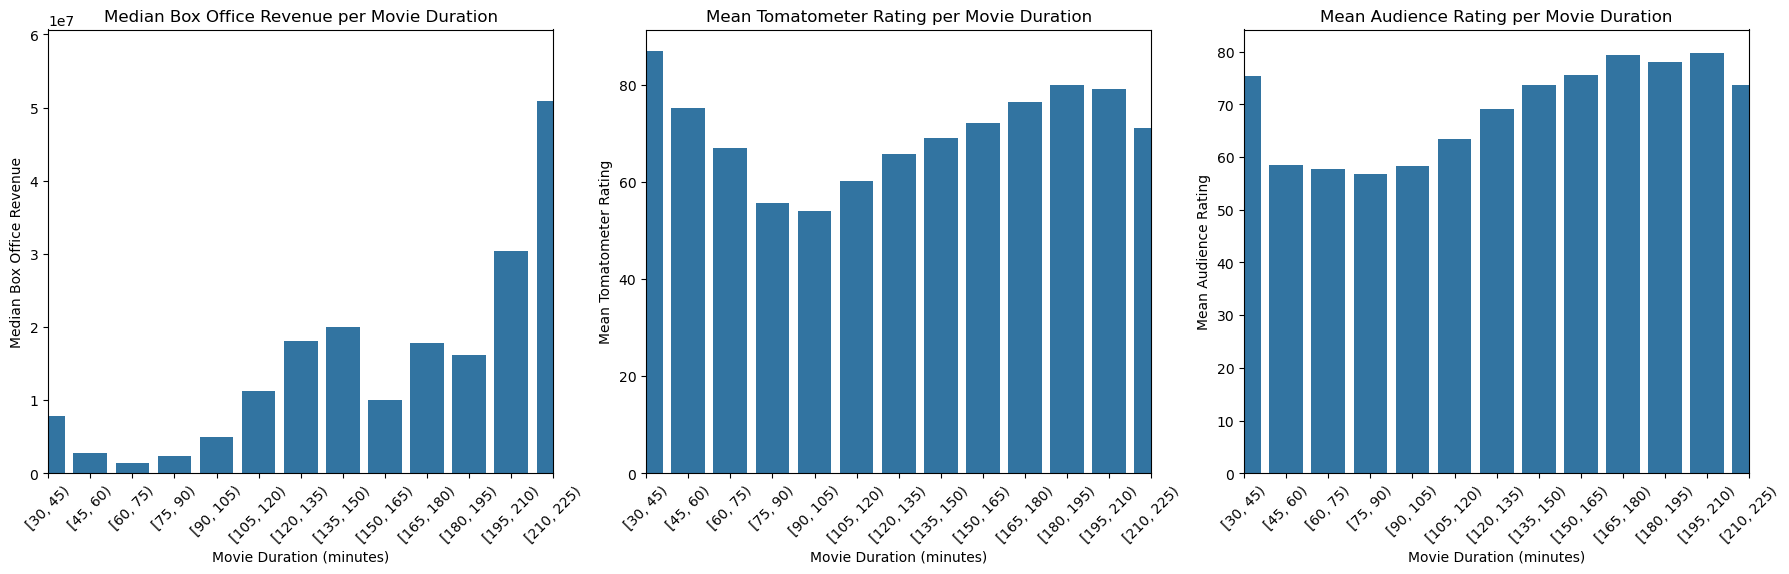

In [105]:
from helpers import convert_and_extract_date, create_length_bins, plot_movie_duration_metrics, explore_month_release_relationship
# Convert the movie release dates to datetime format and extract month and year from the datetime values
movies = convert_and_extract_date(movies)
# Create bins for movie length with a step of 15 minutes up to 300 minutes
filtered_movies, grouped_data = create_length_bins(movies)
# Compare the plots per movie duration for: median box office revenue, mean tomatometer_rating and mean audience_rating
plot_movie_duration_metrics(grouped_data)

A common trend in all 3 graphs is the strict increase of 'success' from the 75-90' movie bucket to the 165-180' movie bucket. We only considered buckets with a large enough sample size to provide more useful insight, a minimum threshold of 25 movie occurrences. Extreme values of box office revenues could heavily influence the mean, so we took the median as we have a big enough sample size and more importantly unskewed data.

### Release Month Graph Analysis & Comparison

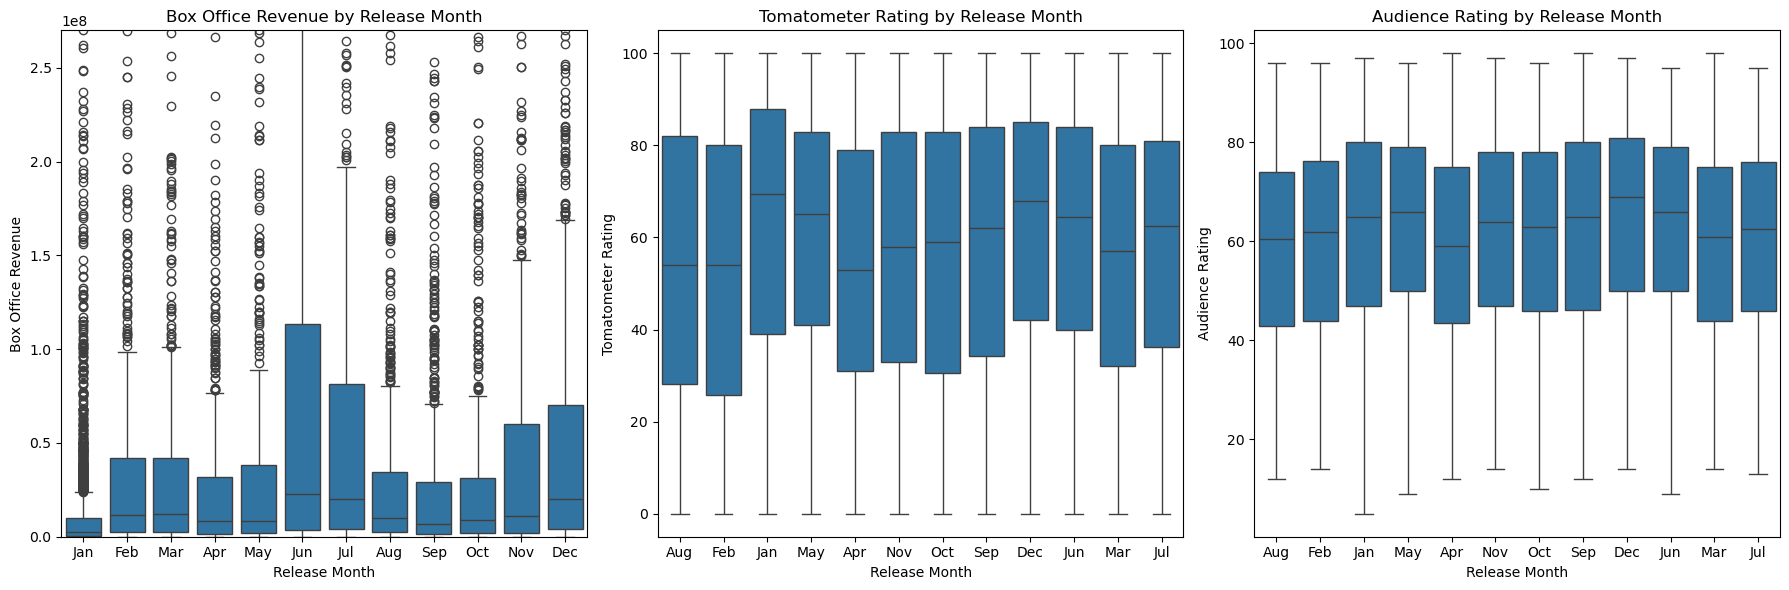

In [106]:
# View the boxplots in monthly order with literal month abbreviations
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Compare the plots per release month for: box office revenue, tomatometer_rating and audience_rating
explore_month_release_relationship(movies, month_order)

It makes sense that there is no significant relation between movie ratings and release month. The interesting plot here is the box office revenue per release month. June, July, November and December are clearly the most profitable movie release months, most likely due to the holiday seasons that can attract more viewers to cinemas. We also notice that the months that follow the holiday season are extremely unprofitable for movie releases, notably January and September: students go back to school after the summer/christmas holidays and general consumers may want to spend less money after their holiday expenses. 

# Topic labelling

In [144]:
movie_topics = pd.read_csv('data/processed_data/movies_topics.csv').set_index("Unnamed: 0")
topics = [
  "Adventure with Creatures",
  "Behind the Scenes of Filmmaking",
  "Crime Investigation",
  "Family Bonds",
  "Family Drama",
  "High School Competition",
  "Life and Love Story",
  "Medieval Fantasy",
  "Mystery in a House",
  "Small Town Conflict",
  "War and Military Action",
]
one_hot_topics = movie_topics[topics]

In [114]:
topic_popularity = pd.Series(one_hot_topics.sum(axis=0), name='Topic popularity')
topic_popularity.sort_values(ascending=False, inplace=True)
topic_popularity.head(20)

Life and Love Story                6655
Family Bonds                       3871
Family Drama                       3418
Crime Investigation                3393
War and Military Action            3131
High School Competition            2614
Mystery in a House                 2609
Medieval Fantasy                   2593
Behind the Scenes of Filmmaking    2454
Small Town Conflict                1779
Adventure with Creatures           1685
Name: Topic popularity, dtype: int64

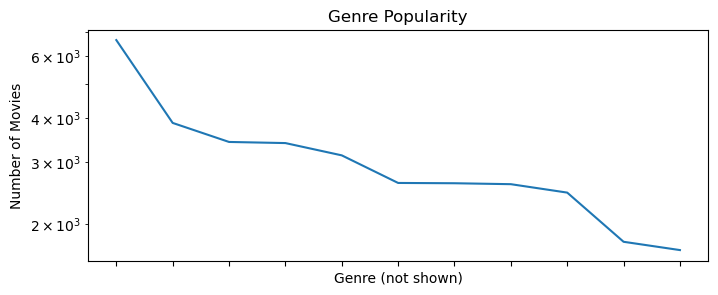

In [115]:
plt.figure(figsize=(8, 3))
plt.semilogy(topic_popularity.index, topic_popularity.values)
plt.tick_params(axis='x', labelbottom=False)
plt.yscale('log')
plt.title('Genre Popularity')
plt.xlabel('Genre (not shown)')
plt.ylabel('Number of Movies')
plt.show()

In [149]:

movie_topics["Topic labels"] = pd.Series(one_hot_topics.apply(lambda row: frozenset(row[row].keys()), axis=1), index=one_hot_topics.index)

In [152]:
movie_topics = movie_topics[movie_topics["Topic labels"].map(len) == 1]
movie_topics["Topic labels"] = movie_topics["Topic labels"].map(lambda labels: list(labels)[0])

In [154]:
SUCCESS_METRICS = ['audience_rating', "tomatometer_rating", "Finantial Success"]

def aggregate_per_topic_labels(movies, name, aggregator_function):
    aggregate = lambda group: pd.Series({
      f"{name} {success_metric}": aggregator_function(group[success_metric])
      for success_metric in SUCCESS_METRICS
    })
    return movies.groupby(by="Topic labels").apply(aggregate)

display(aggregate_per_topic_labels(movie_topics, "Avg", np.nanmean))
display(aggregate_per_topic_labels(movie_topics, "Std", np.nanstd))

,Avg audience_rating,Avg tomatometer_rating,Avg Finantial Success
Topic labels,,,
Adventure with Creatures,57.826923,57.207692,0.340058
Behind the Scenes of Filmmaking,66.778125,67.728125,0.094431
Crime Investigation,60.832695,57.246488,0.192982
Family Bonds,66.696078,63.147059,0.063830
Family Drama,65.559426,60.285861,0.221456
High School Competition,62.405573,51.054180,0.157355
Life and Love Story,62.886510,60.889722,0.068551
Medieval Fantasy,64.772973,61.054054,0.229481
Mystery in a House,53.236677,49.877743,0.187578


,Std audience_rating,Std tomatometer_rating,Std Finantial Success
Topic labels,,,
Adventure with Creatures,19.173621,28.117801,0.473728
Behind the Scenes of Filmmaking,19.920722,26.744587,0.292427
Crime Investigation,20.545159,29.432205,0.394639
Family Bonds,20.034671,29.886188,0.244449
Family Drama,18.436882,28.475997,0.415227
High School Competition,18.749107,27.933831,0.364135
Life and Love Story,18.486408,27.334114,0.252689
Medieval Fantasy,19.467015,28.618786,0.420499
Mystery in a House,20.082247,28.361429,0.390375


## Genre clustering

As we want to compare our various success metrics across genres, we need a way to cluster the movies by their assigned set of genres.
Indeed, the set of genre for each movie will partition the dataset in subsets that are too small for any statistically significant analysis.

Hence, we explore various approaches for clustering our movies along genres.
A natural approach is to use the Jaccard distance, as each of our movies have an entire set of genres instead of a single genre assigned to them.
However, K-means clustering implementations usually do not support smart centroid initialization techniques for the Jaccard distance, and coming up with one is out of the scope of this project.
Moreover, sticking with the Euclidean metric leads to much quicker execution times.

After we obtain clusters, we analyze the differences in each of our success metrics between clusters.



### One-hot encoding

The first step of our analysis consists in one-hot encoding genres to facilitate further processing, and enable a faster computation of the Jaccard distance thanks to NumPy's vectorization.

In [ ]:
def one_hot_encode_genres(movies):
  # Explode the "Movie genres" column to create a new row for each genre
  movies_genres_exploded = movies['Movie genres'].explode()
  # Create new columns for each genre, each cell representing a 0-1 indicator
  # Each row is an all zeros vector with only one coordinate being set to 1
  one_hot_genres = pd.get_dummies(movies_genres_exploded) # , prefix='Genre:', prefix_sep=' ')
  # Group freshly created rows into a single one-hot vector
  one_hot_genres = one_hot_genres.groupby(one_hot_genres.index).sum().astype(bool)
  # Sort the columns to get consistent results
  one_hot_genres = one_hot_genres.reindex(sorted(one_hot_genres.columns), axis=1)
  return one_hot_genres

one_hot_genres = one_hot_encode_genres(movies)

### Most popular genres

As an initial analysis, we explore what are the most popular genres, in the sense how many movies are classified as a certain genre.

In [ ]:
genre_popularity = pd.Series(one_hot_genres.sum(axis=0), name='Genre popularity')
genre_popularity.sort_values(ascending=False, inplace=True)

In [ ]:
genre_popularity.head(20)

Drama               28024
Comedy              14629
Romance Film         8743
Black-and-white      8564
Thriller             7507
Action               7225
World cinema         6967
Indie                6354
Crime Fiction        5844
Short Film           5732
Horror               4380
Adventure            4233
Action/Adventure     4188
Silent film          3987
Documentary          3931
Musical              3700
Family Film          3589
Romantic drama       3197
Mystery              2703
Science Fiction      2606
Name: Genre popularity, dtype: int64

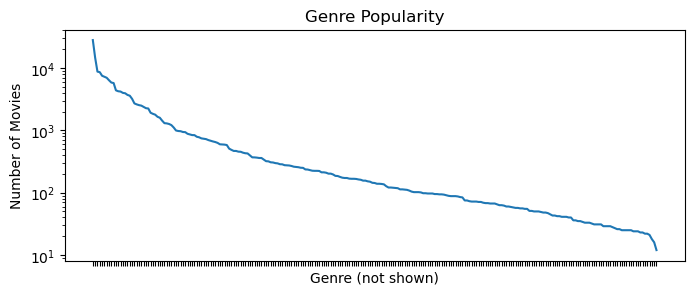

In [ ]:
plt.figure(figsize=(8, 3))
plt.semilogy(genre_popularity.index, genre_popularity.values)
plt.tick_params(axis='x', labelbottom=False)
plt.yscale('log')
plt.title('Genre Popularity')
plt.xlabel('Genre (not shown)')
plt.ylabel('Number of Movies')
plt.show()

We observe that the distribution of genres follows a heavy-tailed distribution.
From this insight, we can retain only the most popular genres without loosing too many data points.
This will come in handy when we will want to cluster the genres, which is a computationally intensive task.
Hence, we take the top $N$ genres where $N$ is determined such that we don't loose more than 1% of all films.

In [ ]:
def determine_number_of_retained_genres(one_hot_genres, genre_popularity, min_percentage):
    number_of_retained_genres = len(genre_popularity)
    retained_movies_percentage = 1.0

    while retained_movies_percentage > min_percentage:
        number_of_retained_genres -= 1

        # Compute the number of movies that would be lost if ignoring the next least popular genre
        popular_genres = list(genre_popularity.head(number_of_retained_genres).index)
        selected_genres = one_hot_genres[popular_genres]

        # Remove movies having no more genre assigned
        retained_movies = selected_genres[selected_genres.any(axis=1)]

        # Update new percentage
        retained_movies_percentage = len(retained_movies) / len(one_hot_genres)
    return number_of_retained_genres, retained_movies

min_percentage = 0.99
number_of_retained_genres, one_hot_genres = determine_number_of_retained_genres(one_hot_genres, genre_popularity, min_percentage)

print(f"Number of retained genres while still keeping {min_percentage*100:.2f}% of movies: {number_of_retained_genres}")
display(one_hot_genres)

Number of retained genres while still keeping 99.00% of movies: 48


,Drama,Comedy,Romance Film,Black-and-white,Thriller,Action,World cinema,Indie,Crime Fiction,Short Film,...,Sports,Family Drama,Parody,Teen,Coming of age,Martial Arts Film,Children's/Family,Television movie,History,Political drama
0,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81737,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81738,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81739,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


### K-Means clustering

Here, we cluster the movies using K-means clustering with the Euclidean distance.

In [29]:
from sklearn.cluster import KMeans

# Silhouette for k = 16: 0.19597367618249606
# Silhouette for k = 19: 0.1985977029778481
# Silhouette for k = 20: 0.19975678343866485
# Silhouette for k = 22: 0.20162250303837756
# Silhouette for k = 24: 0.2050821274124427
# Silhouette for k = 27: 0.21189858971910228
# Silhouette for k = 29: 0.2156625940107003

We now run the $K$-means algorithm for $K = 12$.

In [50]:
k = 12
kmeans = KMeans(n_clusters=k, random_state=0xdeadbeef,n_init=10).fit(one_hot_genres.astype(float))

Now, we analyze the generated clusters and try to identify what kind of movies they contain by seeing the 5 most frequent genres in each cluster.
Along the way, we generate names for our clusters, by taking the most represented genres (or the next if already taken).

In [51]:
TOP_GENRES_COUNT = 5
cluster_names = []

for i, center in enumerate(kmeans.cluster_centers_):
    top_genres_indices = np.argpartition(center, -TOP_GENRES_COUNT)[-TOP_GENRES_COUNT:]
    top_genres = one_hot_genres.columns[top_genres_indices]
    sub_genre_index = 1
    while f"{top_genres[0]}/{top_genres[sub_genre_index]}" in cluster_names:
        sub_genre_index += 1
    cluster_name = f"{top_genres[0]}/{top_genres[sub_genre_index]}"
    cluster_names.append(cluster_name)
    print(f"Cluster #{i} ({cluster_name}): ", ', '.join(top_genres))

Cluster #0 (History/Indie):  History, Indie, Biography, Short Film, Documentary
Cluster #1 (Indie/Black-and-white):  Indie, Black-and-white, Comedy, World cinema, Drama
Cluster #2 (Drama/Indie):  Drama, Indie, Black-and-white, Short Film, Silent film
Cluster #3 (Comedy film/Comedy):  Comedy film, Comedy, Musical, Drama, Romance Film
Cluster #4 (Parody/Black-and-white):  Parody, Black-and-white, Musical, Short Film, Comedy
Cluster #5 (Science Fiction/Comedy film):  Science Fiction, Comedy film, Short Film, Black-and-white, Horror
Cluster #6 (Psychological thriller/Mystery):  Psychological thriller, Mystery, Thriller, Horror, Drama
Cluster #7 (Drama/Action):  Drama, Action, Thriller, Action/Adventure, Adventure
Cluster #8 (Short Film/Adventure):  Short Film, Adventure, Animation, Family Film, Comedy
Cluster #9 (Action/Crime Thriller):  Action, Crime Thriller, Drama, Thriller, Crime Fiction
Cluster #10 (Period piece/World cinema):  Period piece, World cinema, Romantic drama, Romance Film,

Let us also check the size of each cluster:

In [52]:
from collections import Counter
counts = pd.Series(Counter(map(lambda label: cluster_names[label], kmeans.labels_)))
counts.sort_values(ascending=False, inplace=True)
display(counts)

Indie/Black-and-white             16314
Science Fiction/Comedy film        9804
Parody/Black-and-white             6618
Drama/Action                       4766
History/Indie                      3762
Psychological thriller/Mystery     3528
Comedy film/Comedy                 3368
Drama/Indie                        3012
Short Film/Adventure               2728
Action/Crime Thriller              2556
Period piece/World cinema          2434
Romantic drama/Drama               2010
dtype: int64

We now join the results from the clustering to the movies dataframe and print the assigned cluster for blockbusters, as a sanity check:

In [53]:
movies["Genre_cluster"] = pd.Series([cluster_names[int(label)] for label in kmeans.labels_], index=one_hot_genres.index)
display(movies.sort_values(by="Movie box office revenue", ascending=False).head(20)[["Movie name", "Movie genres", "Genre_cluster"]])

,Movie name,Movie genres,Genre_cluster
23702,Avatar,"{Thriller, Fantasy, Nature, Action, Epic, Comp...",Drama/Action
22256,Titanic,"{Costume drama, Romance Film, Drama, Tragedy, ...",Period piece/World cinema
28192,The Avengers,"{Action, Science Fiction}",Drama/Action
30278,Harry Potter and the Deathly Hallows – Part 2,"{Drama, Mystery, Fantasy, Adventure}",Indie/Black-and-white
37601,Iron Man 3,"{Fantasy, Action, Science Fiction, Adventure}",Drama/Action
18645,Transformers: Dark of the Moon,"{Alien Film, Science Fiction, Action, Adventure}",Drama/Action
80920,The Lord of the Rings: The Return of the King,"{Fantasy Adventure, Sword and sorcery films, D...",Indie/Black-and-white
78453,Skyfall,"{Thriller, Action, Adventure}",Drama/Action
54719,The Dark Knight Rises,"{Drama, Crime Fiction, Action, Thriller}",Action/Crime Thriller
2753,Pirates of the Caribbean: Dead Man's Chest,"{Fantasy Adventure, Swashbuckler films, Fantas...",Drama/Action


We observe that some films are mislabelled, however remember that our cluster names are made up, their only purpose is to be able to quickly read the data at a glance. Overall, K-means seems to produce meaningful clusters.

Finally, we observe the mean and standard deviation of our success metrics over each cluster.

In [54]:
SUCCESS_METRICS = ['audience_rating', "tomatometer_rating", "Finantial Success"]

def aggregate_per_cluster(movies, name, aggregator_function):
    aggregate = lambda group: pd.Series({
      f"{name} {success_metric}": aggregator_function(group[success_metric])
      for success_metric in SUCCESS_METRICS
    })
    return movies.groupby(by="Genre_cluster").apply(aggregate)

display(aggregate_per_cluster(movies, "Avg", np.nanmean))
display(aggregate_per_cluster(movies, "Std", np.nanstd))

,Avg audience_rating,Avg tomatometer_rating,Avg Finantial Success
Genre_cluster,,,
Action/Crime Thriller,62.067308,59.659341,0.172492
Comedy film/Comedy,67.776062,66.706564,0.131213
Drama/Action,55.811871,49.351107,0.285714
Drama/Indie,77.843750,93.531250,0.153846
History/Indie,78.062893,84.764151,0.063830
Indie/Black-and-white,69.406061,67.811448,0.094541
Parody/Black-and-white,57.749322,51.084011,0.121818
Period piece/World cinema,67.566406,61.660156,0.139687
Psychological thriller/Mystery,53.769231,52.460165,0.158696


,Std audience_rating,Std tomatometer_rating,Std Finantial Success
Genre_cluster,,,
Action/Crime Thriller,19.672864,27.563003,0.377807
Comedy film/Comedy,17.027234,26.308806,0.337633
Drama/Action,20.043610,29.116820,0.451754
Drama/Indie,13.647595,10.021802,0.360801
History/Indie,12.328923,14.627590,0.244449
Indie/Black-and-white,17.879171,25.238728,0.292579
Parody/Black-and-white,19.301931,29.438623,0.327076
Period piece/World cinema,16.504364,26.202295,0.346662
Psychological thriller/Mystery,20.386891,28.646310,0.365392


These observations fit with our intuition.
For example, independent films (Indie/Comedy) will often be more appreciated by movie critis which are cinephile, while grossing lower due to not having the resources to advertise and pay movie theatres.
On the other hand, fiction movies (Crime Fiction and Science Fiction clusters) have higher standard deviation, which can be interpreted as them being more risky. This can be interpreted as fiction being harder to make credible.

### Genre trends

We also explore trends in genres by plotting histograms of each cluster in function of the release year.
We choose to compare the box-office inflation (adjusted for inflation).
Using this metric, we can plot the proportion of movies of a given genre, weighted by the box-office revenue for each year.

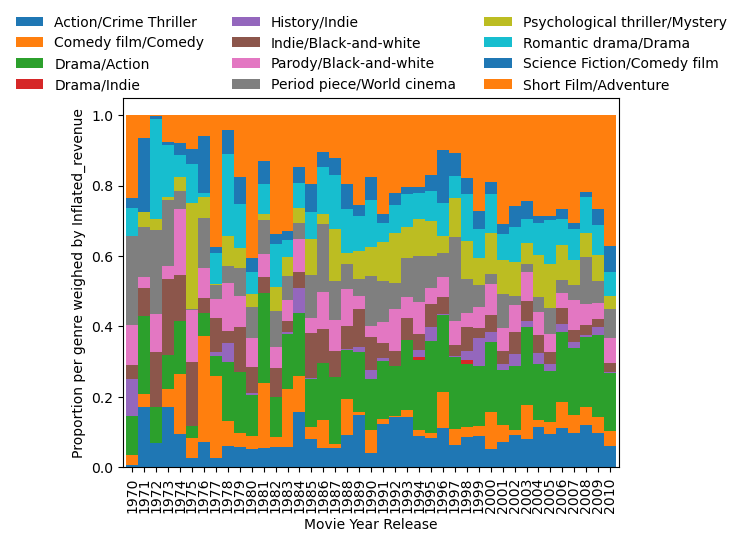

In [55]:
success_metric = 'Inflated_revenue'
movie_trends = movies[["Movie Year Release", "Genre_cluster", success_metric]]
movie_trends = movie_trends.dropna(subset=[success_metric])
movie_trends = movie_trends[movie_trends["Movie Year Release"].isin(range(1970, 2011))]
movie_trends = movie_trends.groupby(["Movie Year Release", "Genre_cluster"])
movie_trends = movie_trends.agg(**{f"Mean {success_metric}": (success_metric, 'mean')})
movie_trends = movie_trends[f"Mean {success_metric}"].unstack(fill_value=0.0)
movie_trends = movie_trends.div(movie_trends.sum(axis=1), axis=0)

movie_trends.plot.bar(stacked=True, width=1.0)
plt.ylabel(f'Proportion per genre weighed by {success_metric}')
plt.legend(
    bbox_to_anchor=(0.5, 1.0),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
plt.show()

We see that less war movies tend to be financially successful nowadays.
However, war movies peaked in the early 70's, which is reminiscent of the Vietnam war, which ended in 1973, afted which the success of such movies seem to decrease.
We are not sure if the success of war movies during this period is indeed causally linked to the Vietnam war and if so, whether it is the effort of U.S. government or anti-war sentiment from Hollywood directors and the general population.
Crime fictions, Science fiction and Thriller movies seem to be growing in popularity.
Consistently with our previous observation, the proportion of movies weighed by revenue of Science fiction movies seems unstable.

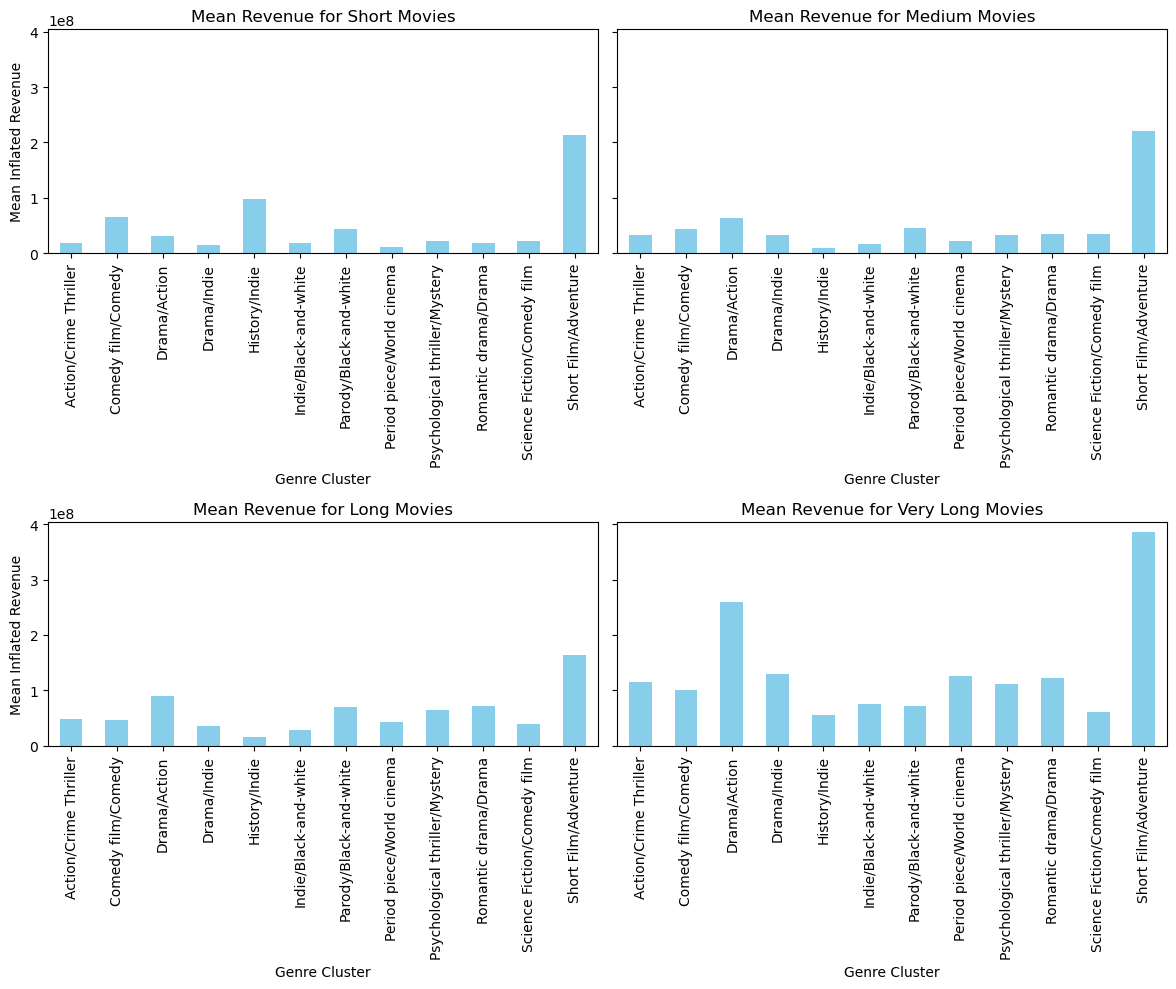

                            OLS Regression Results                            
Dep. Variable:       Inflated_revenue   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     68.31
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           9.71e-44
Time:                        16:59:18   Log-Likelihood:            -2.1717e+05
No. Observations:               10484   AIC:                         4.344e+05
Df Residuals:                   10480   BIC:                         4.344e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [56]:

# Assuming 'movies' is your DataFrame containing the data

# Copy necessary columns
cluster_assignments = movies[['Movie name', 'Genre_cluster']].copy()

# Define labels
labels = ['Short', 'Medium', 'Long', 'Very Long']

# Create movie length bins
movies['Movie_Length_Bin'] = pd.qcut(movies['Movie runtime'], q=4, labels=labels)

# Create subplots for each movie length bin
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

for i, length_bin in enumerate(labels):
    # Filter data for the current movie length bin
    subset = movies[movies['Movie_Length_Bin'] == length_bin]

    # Group by genre cluster and calculate mean revenue
    revenue_comparison = subset.groupby('Genre_cluster')['Inflated_revenue'].mean()

    # Plot bar chart
    revenue_comparison.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Mean Revenue for {length_bin} Movies')
    axes[i].set_xlabel('Genre Cluster')
    axes[i].set_ylabel('Mean Inflated Revenue')

# Adjust layout
plt.tight_layout()
plt.show()

# Fit and print the overall model
model0 = smf.ols(formula='Inflated_revenue ~ C(Movie_Length_Bin)', data=movies).fit()
print(model0.summary())

Here we explain the regression score we find, and draw parallels to the graphs we plot in the revenue comparison

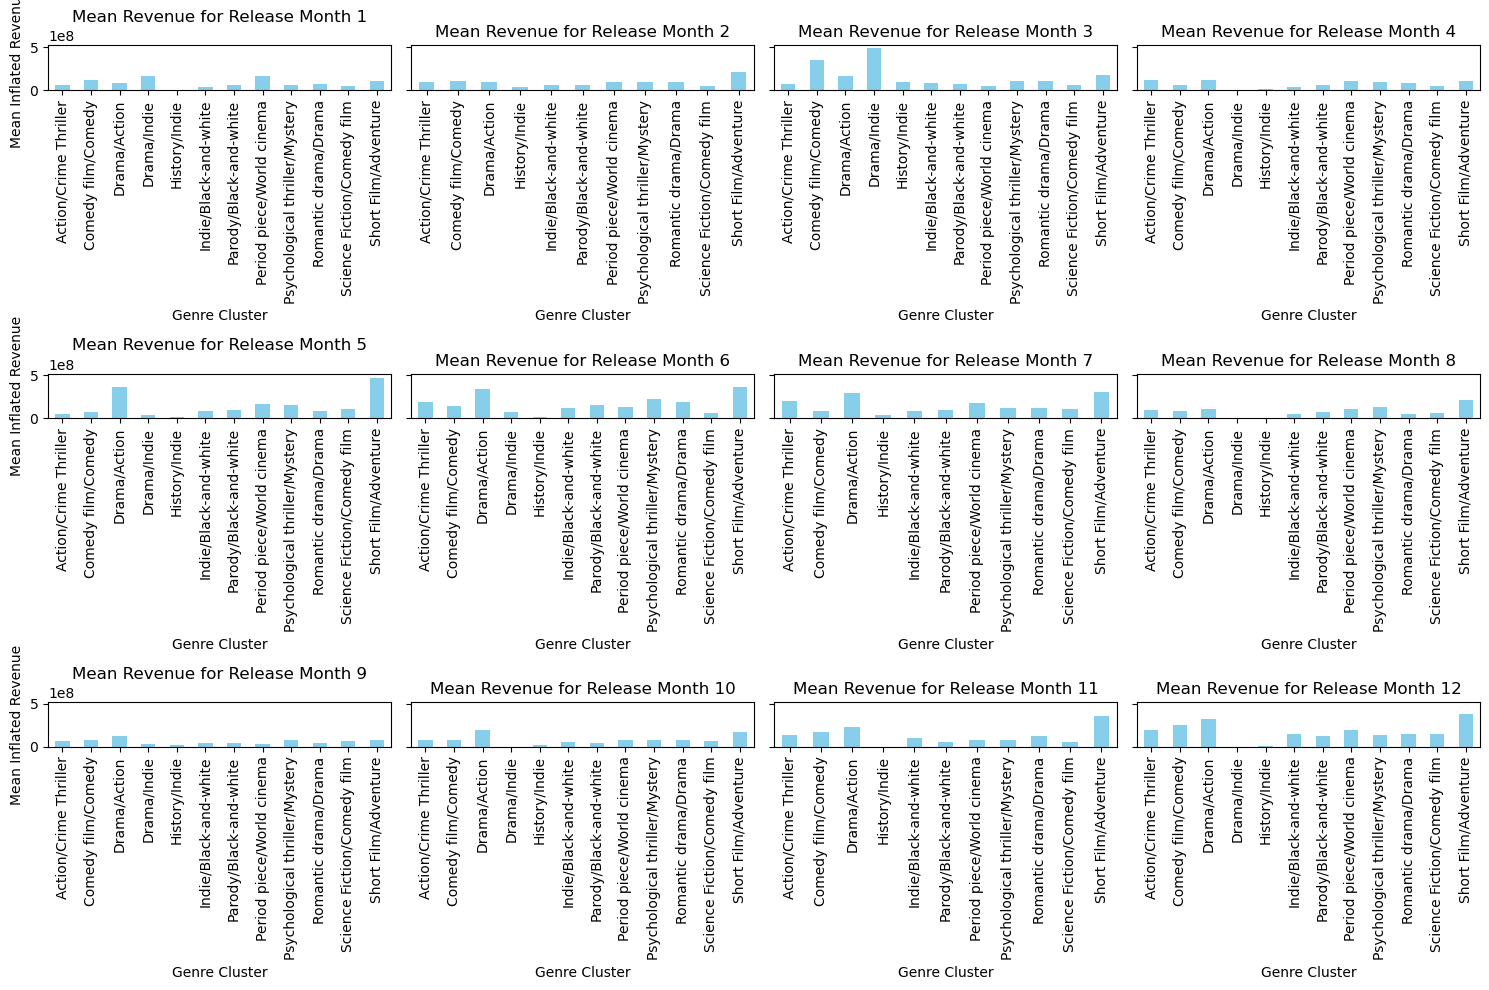

                            OLS Regression Results                            
Dep. Variable:       Inflated_revenue   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     20.44
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           3.80e-41
Time:                        16:59:25   Log-Likelihood:            -1.1639e+05
No. Observations:                5583   AIC:                         2.328e+05
Df Residuals:                    5571   BIC:                         2.329e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [57]:

# Copy necessary columns
cluster_assignments = movies[['Movie name', 'Genre_cluster']].copy()

# Convert release date to datetime and extract month
movies['Release_Month'] = pd.to_datetime(movies['original_release_date']).dt.month

# Create subplots for each release month
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), sharey=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

for i, month in enumerate(range(1, 13)):
    # Filter data for the current release month
    subset = movies[movies['Release_Month'] == month]

    # Group by genre cluster and calculate mean revenue
    revenue_comparison = subset.groupby('Genre_cluster')['Inflated_revenue'].mean()

    # Plot bar chart
    revenue_comparison.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Mean Revenue for Release Month {month}')
    axes[i].set_xlabel('Genre Cluster')
    axes[i].set_ylabel('Mean Inflated Revenue')

# Adjust layout
plt.tight_layout()
plt.show()

# Fit and print the overall model
model1 = smf.ols(formula='Inflated_revenue ~ C(Release_Month)', data=movies).fit()
print(model1.summary())

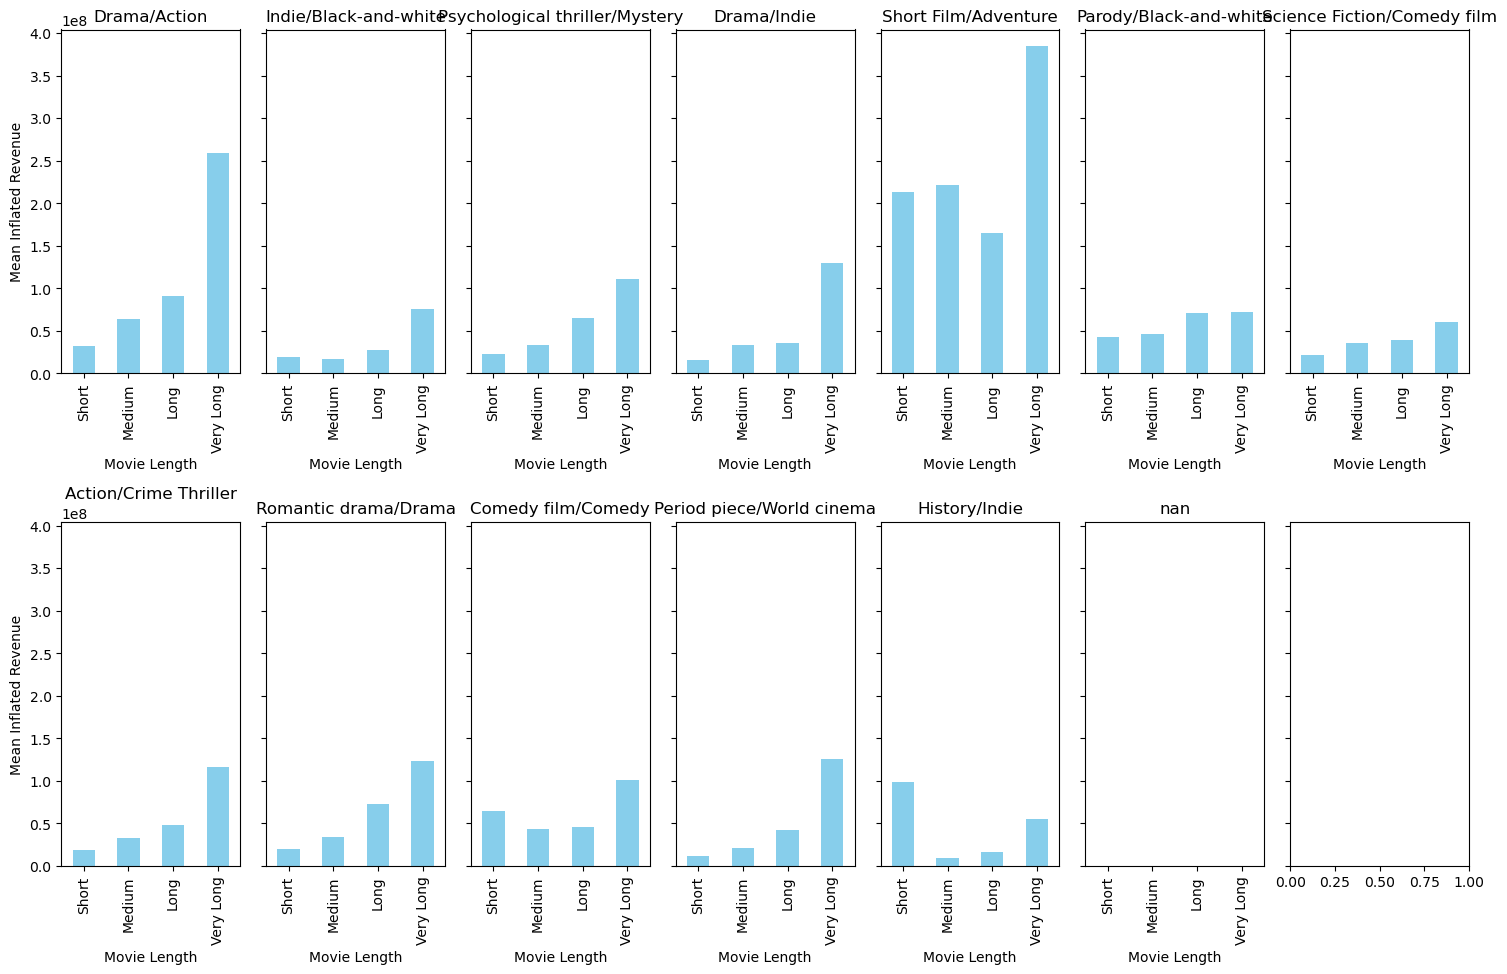

In [77]:
# Get unique genre clusters
unique_genre_clusters = movies['Genre_cluster'].unique()

# Define the number of rows and columns for subplots
num_rows = 2  # You can adjust this based on your preference
num_cols = len(unique_genre_clusters) // num_rows + (len(unique_genre_clusters) % num_rows > 0)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10), sharey=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

for i, selected_genre_cluster in enumerate(unique_genre_clusters):
    # Filter data for the current genre cluster
    genre_cluster_data = movies[movies['Genre_cluster'] == selected_genre_cluster]

    # Group by movie length and calculate mean revenue
    revenue_by_length = genre_cluster_data.groupby('Movie_Length_Bin')['Inflated_revenue'].mean()

    # Plot bar chart on the respective subplot
    revenue_by_length.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(selected_genre_cluster)
    axes[i].set_xlabel('Movie Length')
    axes[i].set_ylabel('Mean Inflated Revenue')

# Adjust layout
plt.tight_layout()
plt.show()

Here we explain the regression score we find, and draw parallels to the graphs we plot in the revenue comparison

In [81]:


# Define a function to calculate similarity for instances with given propensity scores
def get_similarity(score1, score2):
    return 1 - np.abs(score1 - score2)

# Fit generalized least squares to estimate propensity scores
movies_to_match = movies[['Movie_Length_Bin', 'Genre_cluster', 'Inflated_revenue']]
movies_to_match = movies_to_match.dropna(subset=['Movie_Length_Bin', 'Genre_cluster', 'Inflated_revenue'])

mod = smf.ols(formula='Inflated_revenue ~ C(Movie_Length_Bin) + Genre_cluster', data=movies_to_match)
res = mod.fit()

# Extract the estimated propensity scores
movies_to_match['propensity_score'] = res.predict()

# Scale the "propensity_score" column between 0 and 1
scaler = MinMaxScaler()
movies_to_match['propensity_score_z'] = scaler.fit_transform(movies_to_match[["propensity_score"]])

# Separate the treatment and control groups
treatment_group = movies_to_match[movies_to_match['Movie_Length_Bin'] == 'Very Long']
control_group = movies_to_match[movies_to_match['Movie_Length_Bin'] != 'Very Long']

# Subset with 1000 movies in control and treatment
#treatment_group = treatment_group.sample(n=1000, random_state=42)
#control_group = control_group.sample(n=1000, random_state=42)

# Display the number of instances in each category
print("Number of 'Very Long' movies:", len(treatment_group))
print("Number of 'Not Very Long' movies:", len(control_group))
print("Number of 'Long' movies:", len(movies_to_match[movies_to_match['Movie_Length_Bin'] == 'Long']))
print("Number of 'Medium' movies:", len(movies_to_match[movies_to_match['Movie_Length_Bin'] == 'Medium']))
print("Number of 'Short' movies:", len(movies_to_match[movies_to_match['Movie_Length_Bin'] == 'Short']))

restart_long_matching_on_movie_length = False
if (restart_long_matching_on_movie_length):
    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_index, control_row in tqdm(control_group.iterrows(), desc="Matching progress", total=len(control_group)):
        for treatment_index,treatment_row in treatment_group.iterrows():

            # Check conditions for matching
            if (control_row['Genre_cluster'] == treatment_row['Genre_cluster']):

                # Calculate the similarity
                similarity = get_similarity(control_row['propensity_score_z'],treatment_row['propensity_score_z'])

                #print(similarity)

                if (similarity > 0.7): #removes edges to let maxweightmatching terminate but only kept long and very long...

                    # Add an edge between the two instances weighted by the similarity between them
                    G.add_weighted_edges_from([(control_index,treatment_index, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    # Extract pairs of matching indices
    matched_pairs = [(i[0], i[1]) for i in matching]

    # Create a list to hold the matched pairs
    matched_rows = []

    # Iterate through the matched pairs and add the corresponding rows to the list
    for pair in matched_pairs:
        matched_rows.append(movies_to_match.loc[pair[0]])
        matched_rows.append(movies_to_match.loc[pair[1]])

    # Concatenate the matched rows into a new DataFrame
    matched_sample = pd.concat(matched_rows, axis=1).T

    # Display the matched pairs
    display(matched_sample)

    maxWeightMatchedSample = matched_sample.copy()
    maxWeightMatchedSample.to_csv("./maxWeightMatchedSampleMovieLength.csv", index=False)
else:
    # Read the previously saved CSV file
    matched_sample = pd.read_csv("./maxWeightMatchedSampleMovieLength.csv")

    # Display the matched pairs
    display(matched_sample)

Number of 'Very Long' movies: 3919
Number of 'Not Very Long' movies: 6543
Number of 'Long' movies: 3405
Number of 'Medium' movies: 2424
Number of 'Short' movies: 714


,Movie_Length_Bin,Genre_cluster,Inflated_revenue,propensity_score,propensity_score_z
0,Long,Romantic drama/Drama,3.083286e+07,5.801062e+07,0.191202
1,Very Long,Romantic drama/Drama,2.859489e+08,1.344003e+08,0.444928
2,Long,Psychological thriller/Mystery,2.234669e+05,4.776508e+07,0.157172
3,Very Long,Psychological thriller/Mystery,1.638362e+07,1.241547e+08,0.410898
4,Long,Indie/Black-and-white,3.498294e+06,1.456648e+07,0.046904
...,...,...,...,...,...
5691,Very Long,Indie/Black-and-white,3.184559e+07,9.095614e+07,0.300630
5692,Long,Action/Crime Thriller,5.932196e+08,4.309688e+07,0.141667
5693,Very Long,Action/Crime Thriller,6.321084e+06,1.194865e+08,0.395393
5694,Long,Indie/Black-and-white,1.176093e+06,1.456648e+07,0.046904


In [82]:
print(len(matched_sample))

5696


In [83]:
treatment_group["Inflated_revenue"].describe()

count    3.919000e+03
mean     1.307497e+08
std      2.987736e+08
min      1.920308e+00
25%      1.036990e+07
50%      3.904674e+07
75%      1.254816e+08
max      8.421727e+09
Name: Inflated_revenue, dtype: float64

In [84]:
control_group["Inflated_revenue"].describe()

count    6.543000e+03
mean     6.155992e+07
std      1.968196e+08
min      1.699506e+00
25%      2.896024e+06
50%      1.747194e+07
75%      5.107307e+07
max      8.454478e+09
Name: Inflated_revenue, dtype: float64

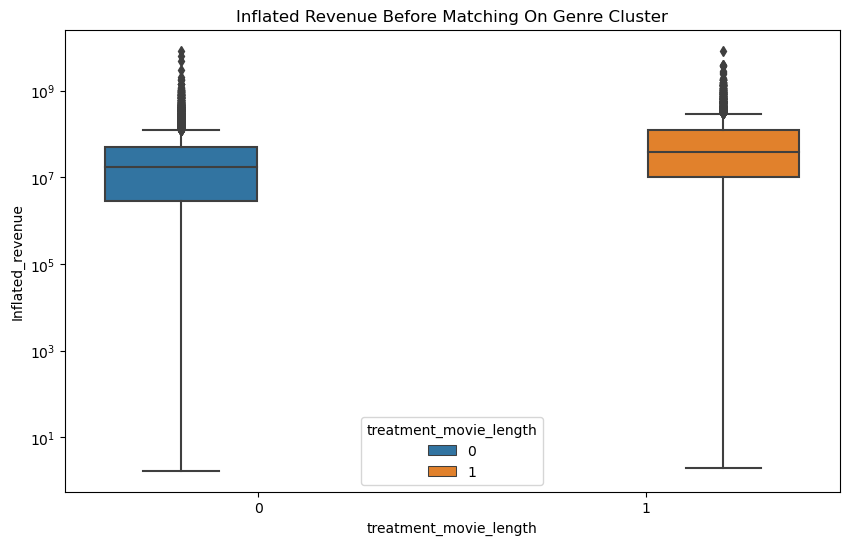

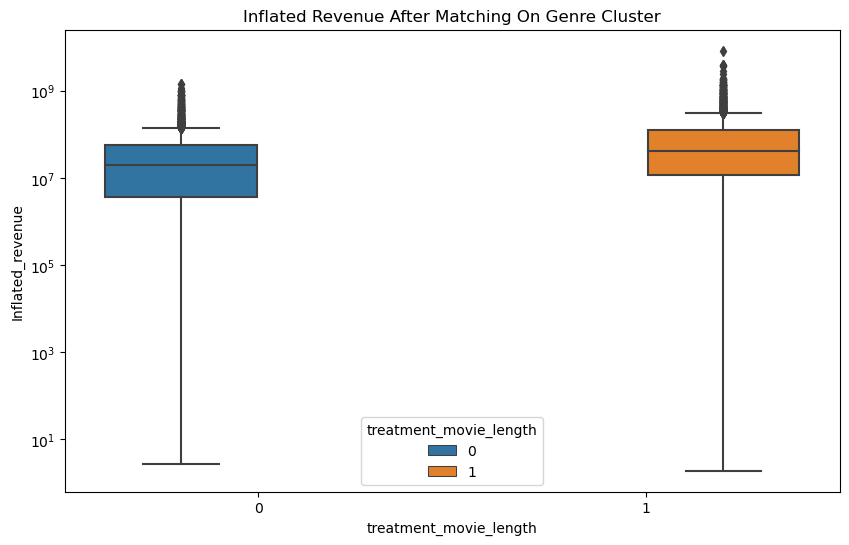

In [85]:


movies_to_match['treatment_movie_length'] = (movies_to_match['Movie_Length_Bin'] == 'Very Long').astype(int)
matched_sample['treatment_movie_length'] = (matched_sample['Movie_Length_Bin'] == 'Very Long').astype(int)

# Boxplot before matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_movie_length', y='Inflated_revenue', data=movies_to_match, hue='treatment_movie_length')
plt.yscale('log')
plt.title('Inflated Revenue Before Matching On Genre Cluster')
plt.show()

# Boxplot after matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_movie_length', y='Inflated_revenue', data=matched_sample, hue='treatment_movie_length')
plt.yscale('log')
plt.title('Inflated Revenue After Matching On Genre Cluster')
plt.show()

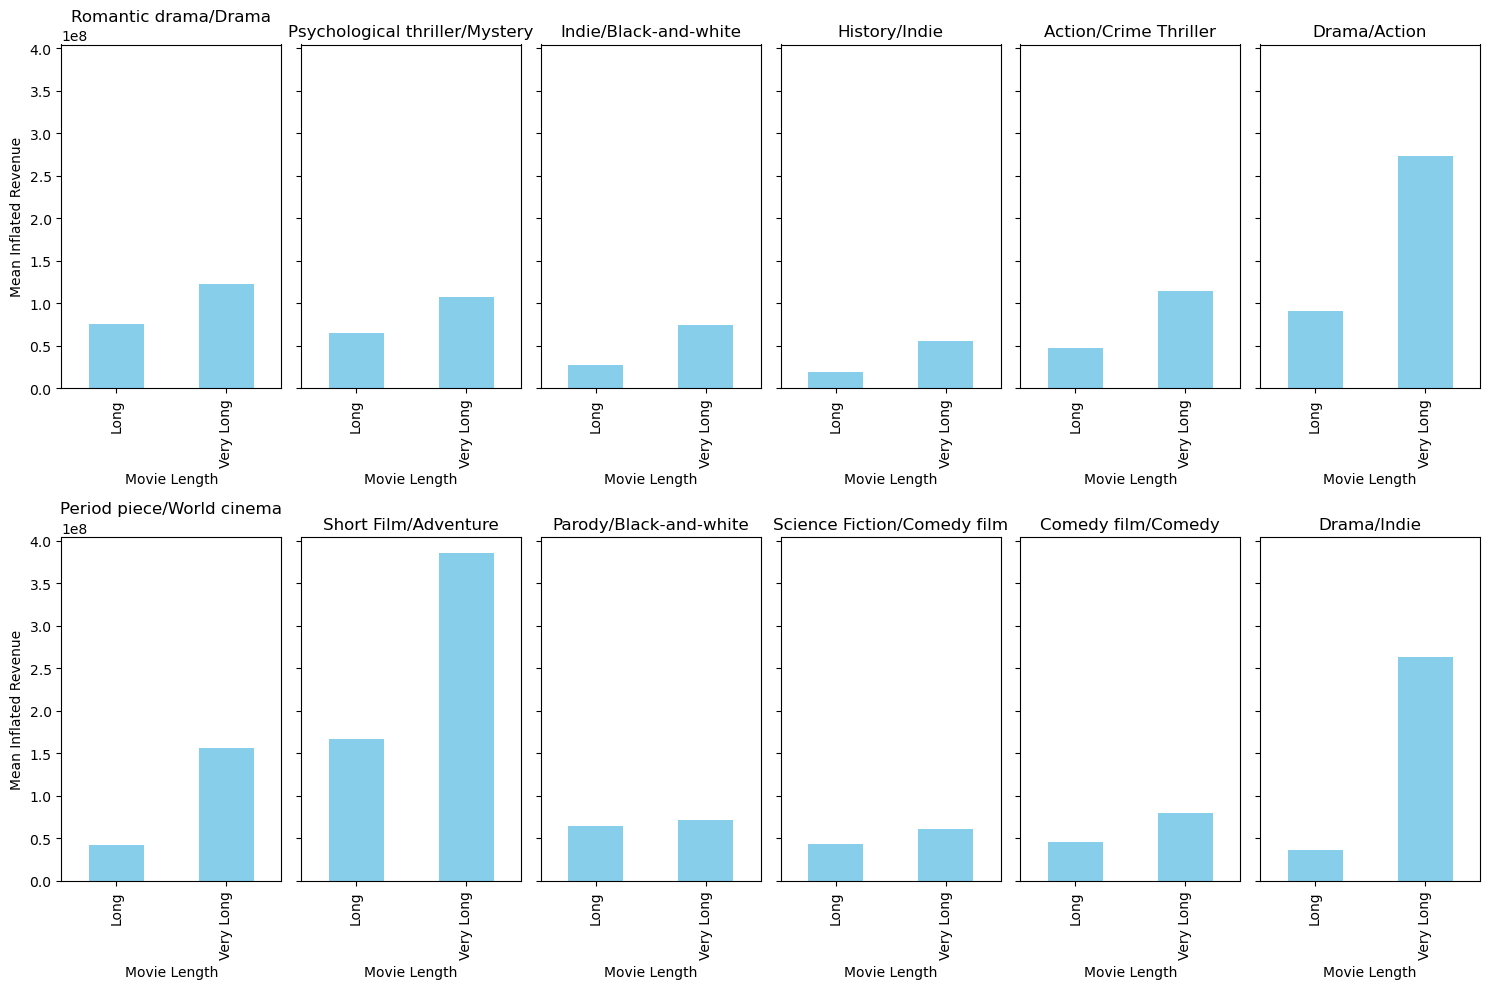

In [86]:
# Get unique genre clusters
unique_genre_clusters = matched_sample['Genre_cluster'].unique()

# Define the number of rows and columns for subplots
num_rows = 2  # You can adjust this based on your preference
num_cols = len(unique_genre_clusters) // num_rows + (len(unique_genre_clusters) % num_rows > 0)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10), sharey=True)

# Flatten the axes for easy iteration
axes = axes.flatten()


for i, selected_genre_cluster in enumerate(unique_genre_clusters):
    # Filter data for the current genre cluster
    genre_cluster_data = matched_sample[matched_sample['Genre_cluster'] == selected_genre_cluster]

    # Group by movie length and calculate mean revenue
    revenue_by_length = genre_cluster_data.groupby('Movie_Length_Bin')['Inflated_revenue'].mean()

    # Plot bar chart on the respective subplot
    revenue_by_length.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(selected_genre_cluster)
    axes[i].set_xlabel('Movie Length')
    axes[i].set_ylabel('Mean Inflated Revenue')

# Adjust layout
plt.tight_layout()
plt.show()

When the treatment movie length equals 1, we are in the treatment group of movies: aka the movies that are considered 'Very Long'. We see that regardless of genre matching, very long movies tend to make more inflated revenue than their shorter counterparts. 

In [87]:


# Fit logistic regression to estimate propensity scores
movies_to_match_month = movies[['Release_Month', 'Genre_cluster', 'Inflated_revenue']]
movies_to_match_month = movies_to_match_month.dropna(subset=['Release_Month', 'Genre_cluster', 'Inflated_revenue'])
mod = smf.ols(formula='Inflated_revenue ~ C(Release_Month) + Genre_cluster', data=movies_to_match_month)
res = mod.fit()

# Extract the estimated propensity scores
movies_to_match_month['propensity_score'] = res.predict()

# Scale the "propensity_score" column between 0 and 1
scaler = MinMaxScaler()
movies_to_match_month['propensity_score_z'] = scaler.fit_transform(movies_to_match_month[["propensity_score"]])

# Separate the treatment and control groups
holiday_months = [6, 7, 11, 12]
treatment_group = movies_to_match_month[movies_to_match_month['Release_Month'].isin(holiday_months)]
control_group = movies_to_match_month[~movies_to_match_month['Release_Month'].isin(holiday_months)]

# Display the number of instances in each category
# Assuming you have a column 'Month' in your DataFrame, adjust accordingly
months = ['January', 'February', 'March','April','May','June','July','August','September','October','November','December']

for month_num in range(1, 13):
    print(f"Number of {months[month_num-1]} movies:", len(movies_to_match_month[movies_to_match_month['Release_Month'] == month_num]))

restart_long_matching_on_release_month = False
if (restart_long_matching_on_release_month):
    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_index, control_row in tqdm(control_group.iterrows(), desc="Matching progress", total=len(control_group)):
        for treatment_index, treatment_row in treatment_group.iterrows():

            # Check conditions for matching

            if (control_row['Genre_cluster'] == treatment_row['Genre_cluster']):
                # Calculate the similarity
                similarity = get_similarity(control_row['propensity_score_z'],treatment_row['propensity_score_z'])
                # print(similarity) # allows max weight matching to converge
                if (similarity > 0.9):
                    # Add an edge between the two instances weighted by the similarity between them
                    G.add_weighted_edges_from([(control_index, treatment_index, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    # Extract pairs of matching indices
    matched_pairs = [(i[0], i[1]) for i in matching]

    # Create a list to hold the matched pairs
    matched_rows = []

    # Iterate through the matched pairs and add the corresponding rows to the list
    for pair in matched_pairs:
        matched_rows.append(movies_to_match_month.loc[pair[0]])
        matched_rows.append(movies_to_match_month.loc[pair[1]])

    # Concatenate the matched rows into a new DataFrame
    matched_sample = pd.concat(matched_rows, axis=1).T

    # Display the matched pairs
    display(matched_sample)

    maxWeightMatchedSample = matched_sample.copy()
    maxWeightMatchedSample.to_csv("./maxWeightMatchedSampleReleaseMonth.csv", index=False)
else:
    # Read the previously saved CSV file
    matched_sample = pd.read_csv("./maxWeightMatchedSampleReleaseMonth.csv")

    # Display the matched pairs
    display(matched_sample)

Number of January movies: 534
Number of February movies: 335
Number of March movies: 404
Number of April movies: 386
Number of May movies: 343
Number of June movies: 464
Number of July movies: 425
Number of August movies: 511
Number of September movies: 512
Number of October movies: 603
Number of November movies: 460
Number of December movies: 603


,Release_Month,Genre_cluster,Inflated_revenue,propensity_score,propensity_score_z
0,5.0,Short Film/Adventure,1.844464e+07,3.125887e+08,0.940605
1,7.0,Short Film/Adventure,1.219531e+09,2.987572e+08,0.903078
2,5.0,Psychological thriller/Mystery,3.213426e+03,1.700690e+08,0.553926
3,7.0,Psychological thriller/Mystery,5.205704e+06,1.562375e+08,0.516399
4,5.0,Short Film/Adventure,6.301818e+05,3.125887e+08,0.940605
...,...,...,...,...,...
681,7.0,Psychological thriller/Mystery,1.541484e+07,1.562375e+08,0.516399
682,5.0,Action/Crime Thriller,4.347943e+05,1.702853e+08,0.554513
683,7.0,Action/Crime Thriller,4.350458e+07,1.564538e+08,0.516986
684,7.0,Romantic drama/Drama,8.751975e+07,1.446088e+08,0.484849


In [88]:
treatment_group["Inflated_revenue"].describe()

count    1.952000e+03
mean     1.910228e+08
std      3.787001e+08
min      1.920308e+00
25%      1.958997e+07
50%      7.538517e+07
75%      2.261036e+08
max      8.454478e+09
Name: Inflated_revenue, dtype: float64

In [89]:
control_group["Inflated_revenue"].describe()

count    3.628000e+03
mean     9.450616e+07
std      1.995005e+08
min      1.699506e+00
25%      1.150816e+07
50%      3.662417e+07
75%      9.884979e+07
max      4.801825e+09
Name: Inflated_revenue, dtype: float64

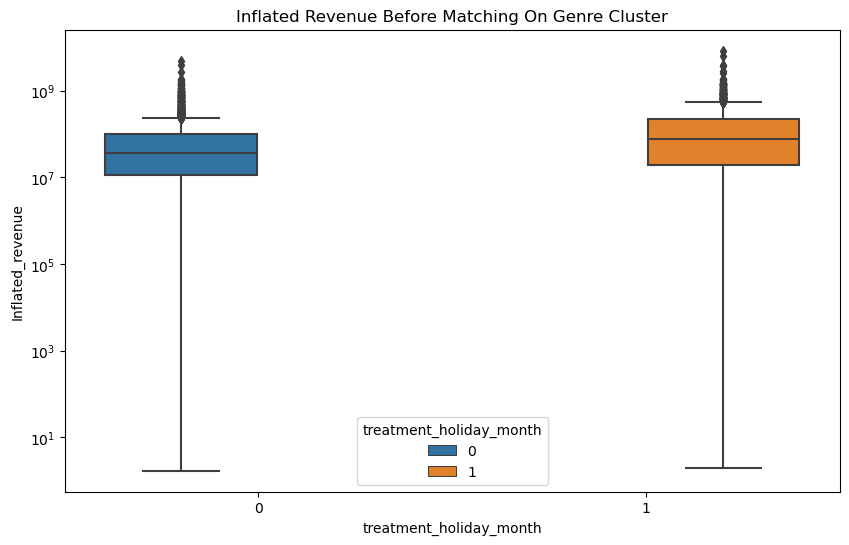

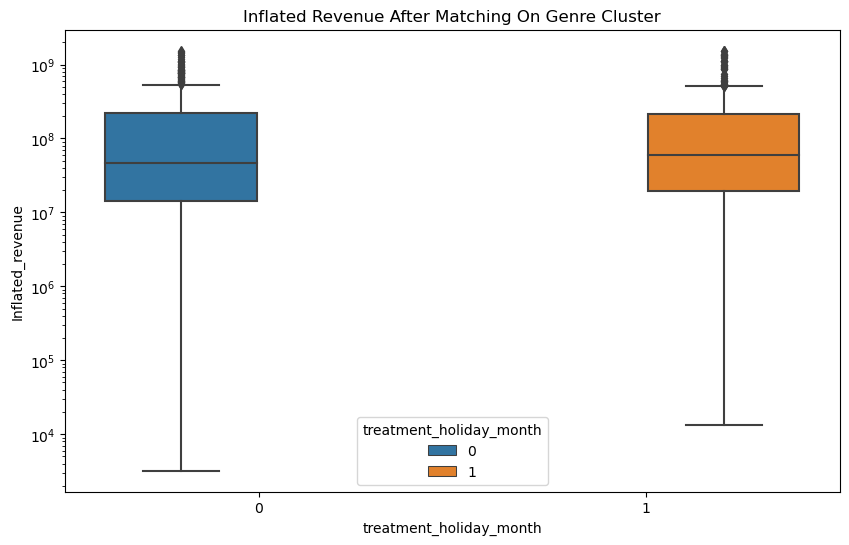

In [90]:

movies_to_match_month['treatment_holiday_month'] = (movies_to_match_month['Release_Month'].isin(holiday_months)).astype(int)
matched_sample['treatment_holiday_month'] = (matched_sample['Release_Month'].isin(holiday_months)).astype(int)

# Boxplot before matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_holiday_month', y='Inflated_revenue', data=movies_to_match_month, hue='treatment_holiday_month')
plt.yscale('log')
plt.title('Inflated Revenue Before Matching On Genre Cluster')
plt.show()

# Boxplot after matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_holiday_month', y='Inflated_revenue', data=matched_sample, hue='treatment_holiday_month')
plt.yscale('log')
plt.title('Inflated Revenue After Matching On Genre Cluster')
plt.show()

When the movie release month is in the summer or christmas holiday season, we are in the treatment group of movies: aka the movies that released in June, July, November or December. We predict that for certain specific genre clusters, the inflated revenue increases more between non-holiday and holiday release months, and that for other genre clusters, the holiday release months will have little to no influence on inflated revenue.

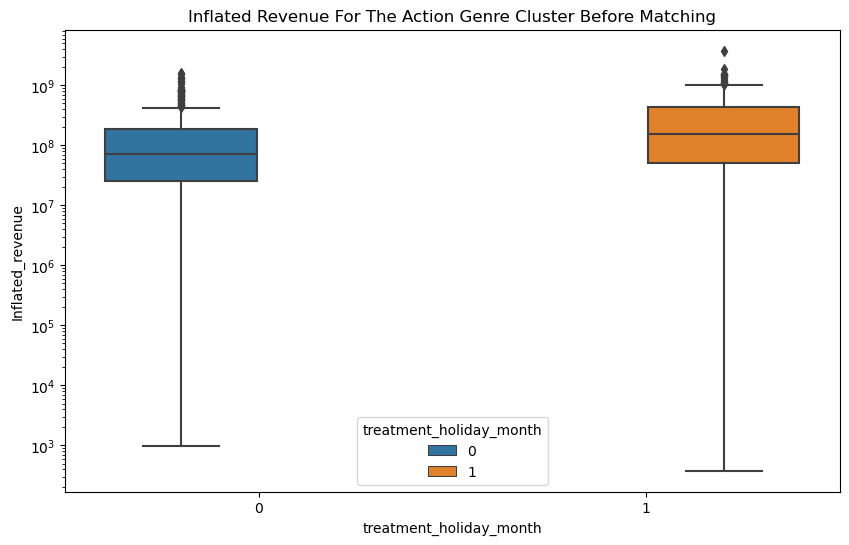

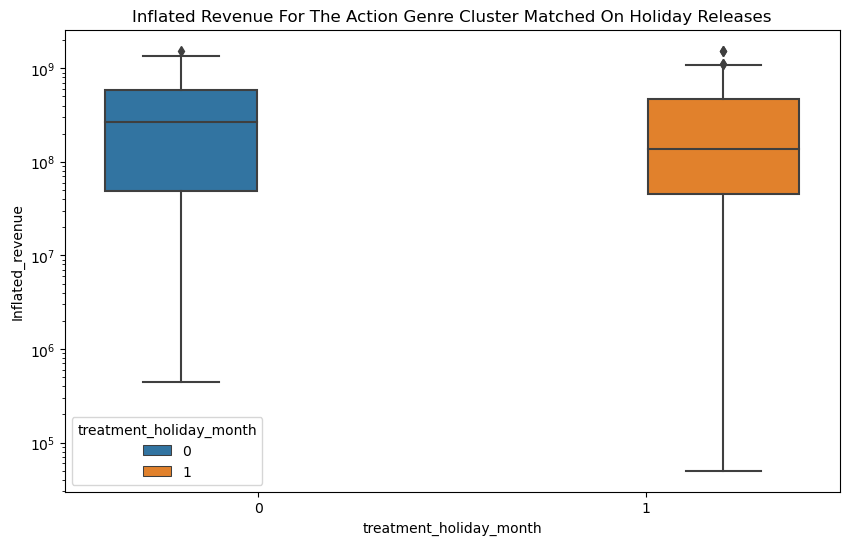

In [91]:
adventure_movies = movies_to_match_month[movies_to_match_month['Genre_cluster']=='Drama/Action']
matched_adventure_movies = matched_sample[matched_sample['Genre_cluster']=='Drama/Action']

# Boxplot before matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_holiday_month', y='Inflated_revenue', data=adventure_movies, hue='treatment_holiday_month')
plt.yscale('log')
plt.title('Inflated Revenue For The Action Genre Cluster Before Matching')
plt.show()

# Boxplot after matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_holiday_month', y='Inflated_revenue', data=matched_adventure_movies, hue='treatment_holiday_month')
plt.yscale('log')
plt.title('Inflated Revenue For The Action Genre Cluster Matched On Holiday Releases')
plt.show()

According to Ampere Analysis: "Film studios aim to take advantage of the Easter, summer and Christmas holidays by releasing light-hearted family-friendly films to which parents can take their children. These typically fall under the genres of action & adventure, comedy and animation". (https://ampereanalysis.com/insight/seasonal-changes-in-the-genres-of-box-office-releases). However from our boxplots, we see that whilst before matching the action movies seemed to have a higher inflated revenue during holiday season, the post-matching boxplots show us that the inflated revenue is similar during and outside of the holiday season.

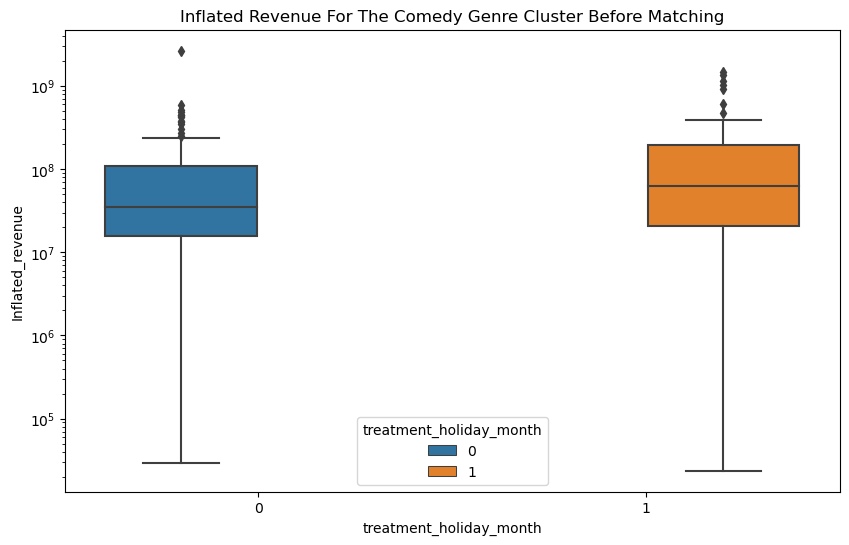

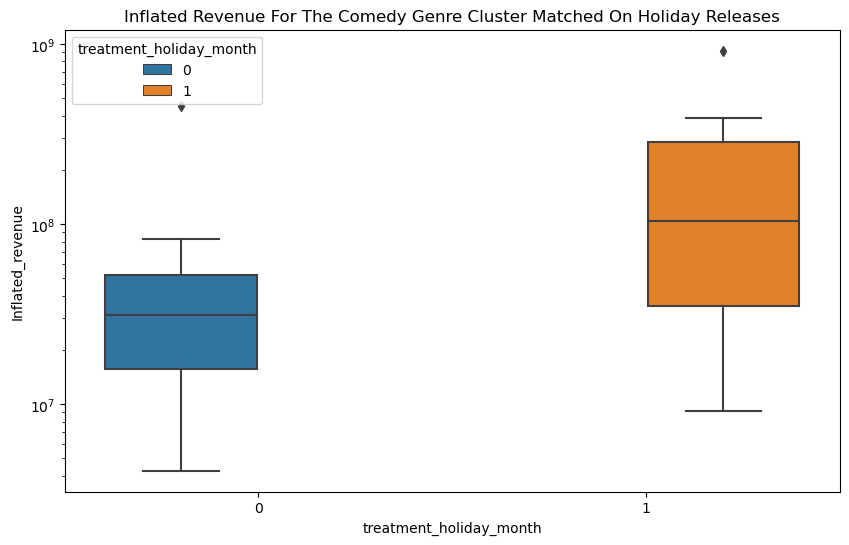

In [92]:
comedy_movies = movies_to_match_month[movies_to_match_month['Genre_cluster']=='Comedy film/Comedy']
matched_comedy_movies = matched_sample[matched_sample['Genre_cluster']=='Comedy film/Comedy']

# Boxplot before matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_holiday_month', y='Inflated_revenue', data=comedy_movies, hue='treatment_holiday_month')
plt.yscale('log')
plt.title('Inflated Revenue For The Comedy Genre Cluster Before Matching')
plt.show()

# Boxplot after matching
plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment_holiday_month', y='Inflated_revenue', data=matched_comedy_movies, hue='treatment_holiday_month')
plt.yscale('log')
plt.title('Inflated Revenue For The Comedy Genre Cluster Matched On Holiday Releases')
plt.show()

Here the quote from Ampere Analysis makes far more sense, we clearly see that given a same quantity matching of holiday and non-holiday movies, the inflated revenue for comedy movies released in holiday months is far greater that the inflated revenue for comedy movies released outside of holiday months. 